# Probability of failure via Monte Carlo simulation - Infinite slope mechanism

© 2024 Exneyder A. Montoya-Araque, Daniel F. Ruiz y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/02_trigg_factors/prob_failure_infinite_slope.ipynb).



## Required modules and global setup for plots

In [1]:
import os
import sys
import subprocess

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    subprocess.run('pip install pynewmarkdisp', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pynewmarkdisp.newmark import direct_newmark, plot_newmark_integration
from pynewmarkdisp.infslope import factor_of_safety, get_ky

%matplotlib widget

# plt.style.use("default")
mpl.rcParams.update(
    {
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

# Create a folder where the records will be saved
workdir = os.getcwd()
records_dir = os.path.join(workdir, "records")
os.makedirs(f"{records_dir}", exist_ok=True)

## Functions

In [2]:
# Function to compute the parameters of the underlying normal distribution
def underlying_parameters(mu_X, sigma_X):
    mu_Y = np.log((mu_X**2) / np.sqrt(sigma_X**2 + mu_X**2))
    sigma_Y = np.sqrt(np.log((sigma_X**2 / mu_X**2) + 1))
    return mu_Y, sigma_Y

def random_sample_uniform(min, max, n, seed=None):
    rng = np.random.default_rng(seed)
    return rng.uniform(min, max, n)

def random_rample_normal(mu, sigma, n, seed=None):
    rng = np.random.default_rng(seed)
    return rng.normal(mu, sigma, n)

def random_sample_lognormal(mu, sigma, n, seed=None):
    mu_und, sigma_und = underlying_parameters(mu, sigma)
    rng = np.random.default_rng(seed)
    return rng.lognormal(mu_und, sigma_und, n)

def compute_confidence_intervals(data, confidence_level=0.95):
    # Prepare arrays for storing the results
    data_mean, data_upper, data_lower, n = [], [], [], []
    
    # Loop through growing subsets of the data
    for n_s in range(5, len(data) + 1):
        subset = data[:n_s]
        mean = np.mean(subset)
        std_dev = np.std(subset, ddof=1)
        # Calculate standard error
        standard_error = std_dev / np.sqrt(n_s)
        # Get t-value for the desired confidence interval
        t_value = sp.stats.t.ppf((1 + confidence_level) / 2., df=n_s - 1)
        # Calculate margin of error
        margin_of_error = t_value * standard_error
        # Store mean and confidence interval bounds
        data_mean.append(mean)
        data_upper.append(mean + margin_of_error)
        data_lower.append(mean - margin_of_error)
        n.append(n_s)
    # Convert lists to arrays for easier plotting and further use
    return np.array(data_mean), np.array(data_upper), np.array(data_lower), np.array(n)

def compute_pf_variation_vector(data, confidence_level=0.95):
    # Prepare arrays for storing the results
    pf_vector, n = [], []
    # Loop through growing subsets of the data
    for n_s in range(5, len(data) + 1):
        subset = data[:n_s]
        failed = np.zeros_like(subset, dtype=int)
        failed[subset < 1] = 1
        pf = np.sum(failed) / n_s
        pf_vector.append(pf)
        n.append(n_s)
    # Convert lists to arrays for easier plotting and further use
    return np.array(pf_vector),  np.array(n)

def compute_std_confidence_intervals(data, confidence_level=0.95):
    # Prepare arrays for storing the results
    std_mean, std_upper, std_lower, n = [], [], [], []
    
    alpha = 1 - confidence_level  # Significance level
    
    # Loop through growing subsets of the data
    for n_s in range(5, len(data) + 1):  # Start at 2 because CI is undefined for n_s = 1
        subset = data[:n_s]
        sample_std = np.std(subset, ddof=1)
        sample_var = sample_std**2
        # Get chi-square critical values
        chi2_lower = sp.stats.chi2.ppf(alpha / 2, df=n_s - 1)
        chi2_upper = sp.stats.chi2.ppf(1 - alpha / 2, df=n_s - 1)
        # Calculate the confidence interval for the standard deviation
        lower_bound = np.sqrt((n_s - 1) * sample_var / chi2_upper)
        upper_bound = np.sqrt((n_s - 1) * sample_var / chi2_lower)
        # Store standard deviation and confidence interval bounds
        std_mean.append(sample_std)
        std_upper.append(upper_bound)
        std_lower.append(lower_bound)
        n.append(n_s)
    # Convert lists to arrays for easier plotting and further use
    return np.array(std_mean), np.array(std_upper), np.array(std_lower), np.array(n)

## Running a case

### Inputs

In [49]:
# Mean values for a deterministic analysis
# ----------------------------------------

## Geometry
β = 35  # [°] - Slope angle - Plane inclination
d = 3.0  # [m] - Depth of the slip surface - Block height
d_w = 3.0  # [m] - Depth of the water table

## Material parameters
φ = 27  # [°] - Friction angle
c = 15  # [kPa] - Cohesion
γ = 19  # [kN/m³] - Unit weight

## Triggering factor
PGA = 0.15  # [g] - Peak ground acceleration



# Uncertainties
# -------------

## Geometry
β_min, β_max = 33, 37  # [°] - Minimum and maximum slope angle (uniform distribution)
d_min, d_max = 2.9, 3.1  # [m] - Minimum and maximum depth of the slip surface (uniform distribution)
d_w_min, d_w_max = d_min, d_max  # [m] - Minimum and maximum depth of the water table (uniform distribution)

## Material parameters
φ_cov = 0.1  # [-] - Coefficient of variation for the friction angle (normal distribution)
c_cov = 0.35  # [-] - Coefficient of variation for the cohesion (lognormal distribution)
γ_cov = 0.01  # [-] - Coefficient of variation for the unit weight (normal distribution)

## Triggering factor
PGA_cov = 0.1  # [-] - Coefficient of variation for the peak ground acceleration (normal distribution)

### Static factor of safety, $\mathrm{FS}_\mathrm{static}$

In [50]:
fs = factor_of_safety(d, d_w, β, φ, c, γ, ks=0)
print(f"Static factor of safety: {fs:.2f}")

Static factor of safety: 1.29


### Pseudo-static factor of safety ($k_s = 0.5 \mathrm{PGA}$)

In [51]:
ks = 0.5 * PGA
fs_det = factor_of_safety(d, d_w, β, φ, c, γ, ks)
print(f"Seismic coefficient, ks: {ks:.3f}")
print(f"Pseudostatic factor of safety: {fs_det:.2f}")

decrease_fs = (fs - fs_det) / fs * 100
print(f"Decrease in factor of safety: {decrease_fs:.2f} %")

Seismic coefficient, ks: 0.075
Pseudostatic factor of safety: 1.13
Decrease in factor of safety: 12.34 %


### Generating random samples

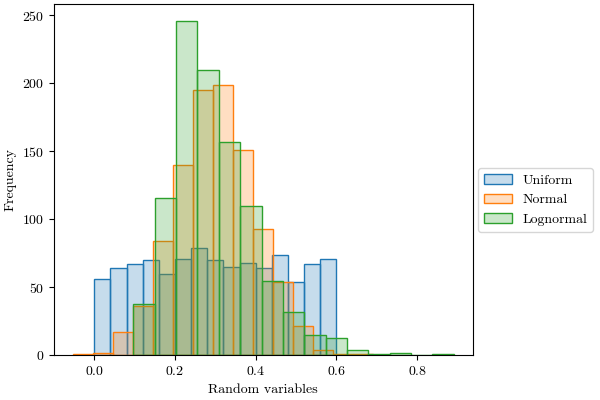

In [52]:
X1 = random_sample_uniform(0.0, 0.6, 1000, seed=123)
X2 = random_rample_normal(0.3, 0.1, 1000, seed=456)
X3 = random_sample_lognormal(0.3, 0.1, 1000, seed=789)


fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
common_pars = {'bins': 15, 'linewidth': 1.0, 'density': False}
ax.hist(X1, color=mpl.colors.to_rgba('C0', alpha=.25), edgecolor='C0', **common_pars, label='Uniform')
ax.hist(X2, color=mpl.colors.to_rgba('C1', alpha=.25), edgecolor='C1', **common_pars, label='Normal')
ax.hist(X3, color=mpl.colors.to_rgba('C2', alpha=.25), edgecolor='C2', **common_pars, label='Lognormal')
ax.set_xlabel("Random variables")
ax.set_ylabel("Frequency")
fig.legend(loc='outside center right')
plt.show()

### Samples for the probabilistic analysis

In [53]:
n_sample = 1000

# Slope angle
β_sample = random_sample_uniform(β_min, β_max, n_sample, seed=111)

# Depth of the slip surface
d_sample = random_sample_uniform(d_min, d_max, n_sample, seed=222)

# Depth of the water table
d_w_sample = random_sample_uniform(d_w_min, d_w_max, n_sample, seed=333)

# Friction angle
tan_φ = np.tan(np.deg2rad(φ))
φ_sd = tan_φ * φ_cov  # Standard deviation of the friction coefficient (tan(φ))
tan_φ_sample = random_rample_normal(tan_φ, φ_sd, n_sample, seed=444)
φ_sample = np.rad2deg(np.arctan(tan_φ_sample))

# Cohesion
c_sd = c * c_cov  # Standard deviation of the cohesion
c_sample = random_sample_lognormal(c, c_sd, n_sample, seed=555)

# Unit weight
γ_sd = γ * γ_cov  # Standard deviation of the unit weight
γ_sample = random_rample_normal(γ, γ_sd, n_sample, seed=666)

# Peak ground acceleration
PGA_sd = PGA * PGA_cov  # Standard deviation of the PGA
PGA_sample = random_rample_normal(PGA, PGA_sd, n_sample, seed=777)

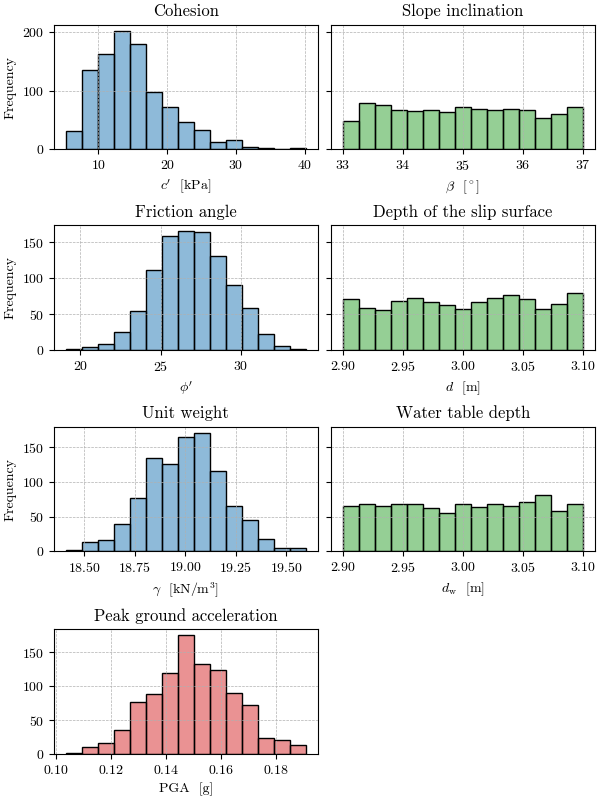

In [54]:
# Plot the histogram of the samples
fig, axs = plt.subplots(nrows=4, ncols=2, layout='constrained', figsize=(6, 8), sharex=False, sharey='row')
fill_col = mpl.colors.to_rgba('C0', alpha=0.5)
common_pars = {'color': fill_col, 'bins': 15, 'edgecolor': 'k', 'linewidth': 1.0, 'density': False}

# Friction angle
axs[1, 0].hist(φ_sample, **common_pars)
# axs[1, 0].set(xlabel="$\\tan \\phi'$", ylabel='Frequency', title='Friction angle')
axs[1, 0].set(xlabel="$\\phi'$", ylabel='Frequency', title='Friction angle')
# Cohesion
axs[0, 0].hist(c_sample, **common_pars)
axs[0, 0].set(xlabel="$c'$  [kPa]", ylabel='Frequency', title='Cohesion')
# Unit weigth
axs[2, 0].hist(γ_sample, **common_pars)
axs[2, 0].set(xlabel="$\\gamma$  [kN/m$^3$]", ylabel='Frequency', title='Unit weight')
# Slope inclination
common_pars['color'] = mpl.colors.to_rgba('C2', alpha=0.5)
axs[0, 1].hist(β_sample, **common_pars)
axs[0, 1].set(xlabel="$\\beta$  [$^\circ$]", title='Slope inclination')
# Depth of the slip surface
axs[1, 1].hist(d_sample, **common_pars)
axs[1, 1].set(xlabel="$d$  [m]", title='Depth of the slip surface')
# Water table depth
axs[2, 1].hist(d_w_sample, **common_pars)
axs[2, 1].set(xlabel="$d_\\mathrm{w}$  [m]", title='Water table depth')
# Peak ground acceleration
common_pars['color'] = mpl.colors.to_rgba('C3', alpha=0.5)
axs[3, 0].hist(PGA_sample, **common_pars)
axs[3, 0].set(xlabel="PGA  [g]", title='Peak ground acceleration')

# Delete the last subplot in the last row
fig.delaxes(axs[3, 1])

for ax in axs.flat:
    ax.grid(True, ls='--', lw=0.5)

fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()


### Calculating FS for all the realizations

In [55]:
ks_sample = 0.5 * PGA_sample
fs_sample = factor_of_safety(d_sample, d_w_sample, β_sample, φ_sample, c_sample, γ_sample, ks_sample)

### Plotting results

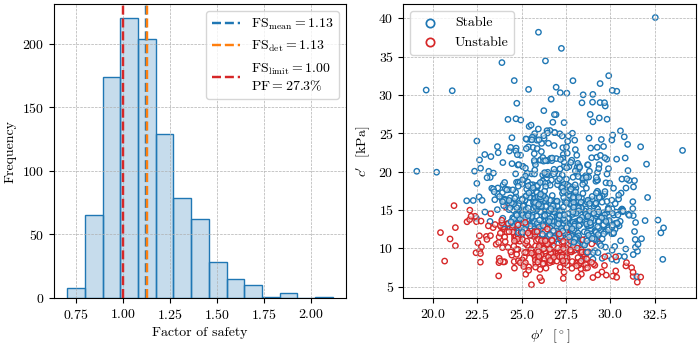

In [56]:
fs_mean = np.mean(fs_sample)
failed = np.zeros_like(fs_sample, dtype=int)
failed[fs_sample < 1] = 1
pf = np.sum(failed) / n_sample

fig, axs = plt.subplots(figsize=(7, 3.5), ncols=2, layout='constrained')
# Histogram of the factor of safety
axs[0].hist(fs_sample, color=mpl.colors.to_rgba('C0', alpha=0.25), edgecolor='C0', bins=15, linewidth=1.0, density=False)
axs[0].axvline(fs_mean, color='C0', linestyle='--', lw=1.75, label=f'$\\mathrm{{FS}}_\\mathrm{{mean}} = {fs_mean:.2f}$')
axs[0].axvline(fs_det, color='C1', linestyle='--', lw=1.75, label=f'$\\mathrm{{FS}}_\\mathrm{{det}} = {fs_det:.2f}$')
axs[0].axvline(1, color='C3', linestyle='--', lw=1.75, label=f'$\\mathrm{{FS}}_\\mathrm{{limit}} = 1.00$\n$\\mathrm{{PF}} = {100*pf:.1f}\%$')
axs[0].set(xlabel='Factor of safety', ylabel='Frequency')

# Scatter plot of cohesion vs friction angle
edge_cols = np.array(['C0', 'C3'])
axs[1].scatter(φ_sample, c_sample, edgecolors=edge_cols[failed], linewidths=1.0, s=15,
               facecolors=mpl.colors.to_rgba('w', alpha=0.5))
axs[1].set(xlabel="$\\phi'$  [$^\circ$]", ylabel="$c'$  [kPa]")
for label, format in zip(['Stable', 'Unstable'], ['C0', 'C3']):
    axs[1].scatter([], [], marker='o', edgecolors=format, facecolors='w', label=label, linewidths=1.25)


for ax in axs.flat:
    ax.grid(True, ls='--', lw=0.5)
    ax.legend(loc='best')

fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()


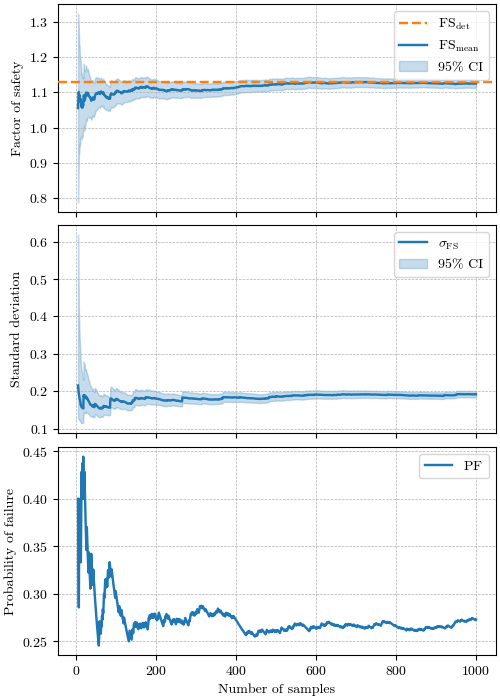

In [60]:
fig, axs = plt.subplots(figsize=(5, 7), nrows=3, layout='constrained', sharex=True)
# Compute the confidence intervals for the mean
fs_mean, fs_upper, fs_lower, n = compute_confidence_intervals(fs_sample)
axs[0].axhline(fs_det, color='C1', ls='--', lw=1.75, label='$\\mathrm{FS}_\\mathrm{det}$', zorder=3)
axs[0].plot(n, fs_mean, 'C0', ls='-', lw=1.75, label='$\\mathrm{FS}_\\mathrm{mean}$')
axs[0].fill_between(n, fs_upper, fs_lower, color='C0', alpha=0.25, label='95% CI')
axs[0].set(ylabel='Factor of safety')

# Compute the confidence intervals for the standard deviation
fs_std_mean, fs_std_upper, fs_std_lower, n = compute_std_confidence_intervals(fs_sample)
axs[1].plot(n, fs_std_mean, 'C0', ls='-', lw=1.75, label='$\\sigma_{\\mathrm{FS}}$')
axs[1].fill_between(n, fs_std_upper, fs_std_lower, color='C0', alpha=0.25, label='95% CI')
axs[1].set(ylabel='Standard deviation')

# Compute the confidence intervals for the probability of failure
pf_vector, n = compute_pf_variation_vector(fs_sample)
axs[2].plot(n, pf_vector, 'C0', ls='-', lw=1.75, label='$\\mathrm{PF}$')
axs[2].set(xlabel='Number of samples', ylabel='Probability of failure')

for ax in axs.flat:
    ax.grid(True, ls='--', lw=0.5)
    ax.legend(loc='best')

fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()

